## **Variational Quantum Classifier**

 This notebook attempts to explore the Pennylane tutorial, dedicated to Variational Quantum Classifier ([VQC](https://pennylane.ai/qml/demos/tutorial_variational_classifier/)). Two interesting tasks will be investigated, namely the imitation of the parity function and the classification of two classes in the well-known Iris dataset ([Iris](https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data/)).  After going through different levels of implementation for VQC, a different yet intriguing scheme, appropriate for classification tasks is stated, which we would like to consider and reflect upon for our future investigations.

In [1]:
!pip install pennylane --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 16.4 MB/s eta 0:00:00


In [2]:
"Importing the necessary libraries and dependencies:"
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pennylane as qml
import pennylane.numpy as np
from pennylane.optimize import GradientDescentOptimizer, NesterovMomentumOptimizer, AdamOptimizer

In [3]:
dev = qml.device("default.qubit")

## ***Emulating The Parity Function via Variational Circuits***

We wish to construct a variational circuit. These can be set up by layers whose repetition (via training) would typically lead to more refined results in terms of convergence to the result we are looking for. This job in our quantum circuit is reserved for arbitrary parameterised single and two-qubit gates (entanglers). This can be achieved via the arbitrary Rot gate and CNOTs in between every single qubits (wires). This rationale will grant each qubit with the necessary freedom while connecting them with each other to increase sensitivity of correlations. The parameters are called weights, in conjunction with Machine Learning nomenclature.

In [4]:
def layer(layer_weights):
    for wire in range(4):
        qml.Rot(*layer_weights[wire], wires=wire)

    for wires in ([0, 1], [1, 2], [2, 3], [3, 0]):
        qml.CNOT(wires)

But then we need to introduce our data to the circuit for it to be able to work on. This is a highly non-trivial task (as is evident by the instance in the Iris dataset later), but in this case, it's much more convenient. We simply note the binary strings of our input and analogize it with the state of the qubits. Where "1" is observed, simply a PauliX gate is effected, whereas the corresponding wires with "0"s are left alone. This is automatically handled by BasisState() state-preparation in Pennylane and it deals with that via big-endian encoding!

In [5]:
def state_preparation(x):
    qml.BasisState(x, wires=[0, 1, 2, 3])


Basically, the state-preparation is followed by repeatedly applying our weighted layers. The output of the QNode is 1 or -1, which is potentially aligned with the results we are seeking (albeit with the effect of some tweaking to fit the scenario later for comparisons in the following).

In [6]:
@qml.qnode(dev)
def circuit(weights, x):
    state_preparation(x)

    for layer_weights in weights:
        layer(layer_weights)

    return qml.expval(qml.PauliZ(0))


In essence, when we talk about variational settings, we almost always implicitly allude to the existence of "classical" entities. Now, here we have the option of adding a trainable classical bias parameter that can be optimized later, which aids with better data fitting eventually. For that purpose, we sum the output of our quantum circuit with the bias parameter.

In [7]:
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias


  This is the stage, where we define cost functions. Now technically these differ from loss functions, and in Supervised Learning the relation between them is as follows. Cost functions are usually defined as the sum of a loss function with a regularizer (e.g., L1 or L2). A standard choice for loss functions is square_loss and it's acheived by squaring the difference between our labels and our predictions (the end result of all the levels of training on our trainig set). We can also define a custom function for accuracy, which trails the number of correct predictions divided by the number of elements in our label set. Now, we can guage the level of a datapoint being as accurate via a threshold (here one can choose up to 4 decimals).

In [8]:
def square_loss(labels, predictions):
    # We use a call to qml.math.stack to allow subtracting the arrays directly
    return np.mean((labels - qml.math.stack(predictions)) ** 2)


In [9]:
def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 1e-4 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc


In [10]:
def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)


Now we need to upload our training and test sets from the parity dataset. These are downloaded from ([VQC](https://pennylane.ai/qml/demos/tutorial_variational_classifier/)) and fed into Google Colab so that they can be called upon at will.

In [11]:
from google.colab import files
uploaded = files.upload()

Saving parity_train.txt to parity_train.txt


In [12]:
from google.colab import files
uploaded = files.upload()

Saving parity_test.txt to parity_test.txt


We load the data, and specify the label by Y. Our training datapoints will be denoted by X. With further inspection, we can observe that a shift is needed for the labels to be compliant with the procedures defined above (e.g., in terms of the output produced by the layers). We need to confirm we have the data as required. Indeed, this is the case.

In [13]:
data = np.loadtxt("parity_train.txt", dtype=int)
X = np.array(data[:, :-1])
Y = np.array(data[:, -1])
Y = Y * 2 - 1  # shift label from {0, 1} to {-1, 1}

for x,y in zip(X, Y):
    print(f"x = {x}, y = {y}")


x = [0 0 0 1], y = 1
x = [0 0 1 0], y = 1
x = [0 1 0 0], y = 1
x = [0 1 0 1], y = -1
x = [0 1 1 0], y = -1
x = [0 1 1 1], y = 1
x = [1 0 0 0], y = 1
x = [1 0 0 1], y = -1
x = [1 0 1 1], y = 1
x = [1 1 1 1], y = -1


Now, we use standard scaling (the parameters between 0 and 1) for random generation of our initial weights to be fed to the pipeline (to be optimized for the end results). Some other hyperparameters are denoted below. We choose bias 0, which of course represents the other trainable entity to be involved in optimization.

In [14]:
np.random.seed(42)
num_qubits = 4
num_layers = 2
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

print("Weights:", weights_init)
print("Bias: ", bias_init)


Weights: [[[ 0.00496714 -0.00138264  0.00647689]
  [ 0.0152303  -0.00234153 -0.00234137]
  [ 0.01579213  0.00767435 -0.00469474]
  [ 0.0054256  -0.00463418 -0.0046573 ]]

 [[ 0.00241962 -0.0191328  -0.01724918]
  [-0.00562288 -0.01012831  0.00314247]
  [-0.00908024 -0.01412304  0.01465649]
  [-0.00225776  0.00067528 -0.01424748]]]
Bias:  0.0


Several optimizers are available to choose from, and handling the correct choice seems to be a delicate matter, not at all trivial. For example, ([Optimizers](https://pennylane.ai/blog/2022/06/how-to-choose-your-optimizer/tutorial_variational_classifier/)) is a good resource to build an intuition around this direction. One choice can be NesterovMomentumOptimizer, which is a good choice for landscapes with tricky curvatures or saddle points ([Nesterov](https://deepai.org/machine-learning-glossary-and-terms/nesterovs-momentum)). It involves adjusting two hyperparameters of step_size and momentum. We choose step_size = 0.4 and batch_size = 5 in which the latter is indicative of processing that amount of data for training in one go. This can be adjusted not to be the entire dataset, which is not reasonable if the dataset is huge! We perform the training for n epochs (another hyperparameter), namely this procedure will be repeated n times. Also because we have trained the bias, the whole output may go outside the boundary of [-1, 1], so we use np.sign to bring it back to the format [-1 or 1] for checking with the labels. With these settings, already at iteration around 20 we have stable training accuracy=1. For lowering the cost, more iterations are needed.

In [15]:
opt = NesterovMomentumOptimizer(0.4)
batch_size = 5


weights = weights_init
bias = bias_init
for it in range(90):

    # Update the weights by one optimizer step, using only a limited batch of data
    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias = opt.step(cost, weights, bias, X=X_batch, Y=Y_batch)

    # Compute accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]

    current_cost = cost(weights, bias, X, Y)
    acc = accuracy(Y, predictions)

    print(f"Iter: {it:4d} | Cost: {current_cost:0.8f} | Accuracy: {acc:0.8f}")


Iter:    0 | Cost: 2.53620672 | Accuracy: 0.50000000
Iter:    1 | Cost: 1.97740459 | Accuracy: 0.50000000
Iter:    2 | Cost: 1.99137667 | Accuracy: 0.50000000
Iter:    3 | Cost: 2.18549957 | Accuracy: 0.50000000
Iter:    4 | Cost: 1.32594754 | Accuracy: 0.50000000
Iter:    5 | Cost: 0.99828218 | Accuracy: 0.50000000
Iter:    6 | Cost: 0.94972016 | Accuracy: 0.60000000
Iter:    7 | Cost: 1.00209783 | Accuracy: 0.60000000
Iter:    8 | Cost: 1.47944212 | Accuracy: 0.40000000
Iter:    9 | Cost: 1.02022744 | Accuracy: 0.60000000
Iter:   10 | Cost: 1.00989356 | Accuracy: 0.60000000
Iter:   11 | Cost: 0.97576235 | Accuracy: 0.60000000
Iter:   12 | Cost: 0.93303721 | Accuracy: 0.40000000
Iter:   13 | Cost: 0.96645382 | Accuracy: 0.60000000
Iter:   14 | Cost: 1.06443976 | Accuracy: 0.60000000
Iter:   15 | Cost: 0.59190666 | Accuracy: 0.80000000
Iter:   16 | Cost: 0.24606961 | Accuracy: 1.00000000
Iter:   17 | Cost: 0.03574971 | Accuracy: 1.00000000
Iter:   18 | Cost: 0.00490907 | Accuracy: 1.00

Of course, Machine Learning's goal is to perform generalization. Thus, we must test our model on unseen data, in this case our test dataset. Otherwise, overfitting occurs, wherein the model is so attached to the training data that it only can understand those specific instances and doesn't have the freedom to explore other cases.

In [16]:
data = np.loadtxt("parity_test.txt", dtype=int)
X_test = np.array(data[:, :-1])
Y_test = np.array(data[:, -1])
Y_test = Y_test * 2 - 1  # shift label from {0, 1} to {-1, 1}

predictions_test = [np.sign(variational_classifier(weights, bias, x)) for x in X_test]

for x,y,p in zip(X_test, Y_test, predictions_test):
    print(f"x = {x}, y = {y}, pred={p}")

acc_test = accuracy(Y_test, predictions_test)
print("Accuracy on unseen data:", acc_test)


x = [0 0 0 0], y = -1, pred=-1.0
x = [0 0 1 1], y = -1, pred=-1.0
x = [1 0 1 0], y = -1, pred=-1.0
x = [1 1 1 0], y = 1, pred=1.0
x = [1 1 0 0], y = -1, pred=-1.0
x = [1 1 0 1], y = 1, pred=1.0
Accuracy on unseen data: 1.0


Perfect result! Indeed the model is predictive and can take care of unseen examples!

## ***Binary classification for two classes of the Iris Dataset:***

For this initial phase of the embedding choice for our VQC (by amplitude encoding, which usually gives leverage in terms of accuracy, compared to other implementations e.g., according to ([Variational Quantum Classifier for Binary Classification](https://ieeexplore.ieee.org/document/9665779)). Of course, it is a linear embedding and these bring with themselves limitations), we need to apply the method in ([Mottonen](https://arxiv.org/abs/quant-ph/0407010)).











Now in this instance, somewhat aligned with ([Positive subspace](https://link.springer.com/book/10.1007/978-3-319-96424-9)), we do not deal with signs. Because we do not need to take care of phases, we deal only with controlled-RY gates in state preparation (cf. equation (8) and figure[3] in ([Mottonen](https://arxiv.org/abs/quant-ph/0407010)) for more details). The resurrection of our data in the form of our states, which is a part of the general scheme (as laid out in that paper) comprises applying an RY gate to the qubit 0, a controlled-RY (ctrl=0, target=1) with control value 1, and a controlled-RY (ctrl=0, target=1) with control value 0. Now, this can be further simplified, according to figure 4.6 in ([Nielsen&Chuang](https://archive.org/details/QuantumComputationAndQuantumInformation10thAnniversaryEdition/page/n213/mode/2up)). If one chooses A=RY(theta/2), B=RY(-theta/2), and C=I, one can regenerate the gates required for this purpose!

In [17]:
"This recipe is made by noticing the fact that we want to encode a two-qubit state (4 components)."
"Now if we demonstrate that possibility by [x_0  x_1  x_2  x_3] = x_0 |00> + x_1 |01> + x_2 |10> +x_3 |11>"
"and take note of Mottonen paper's construction, the procedure is laid out below equation (5) by which we need"
"to transform the values on state |1> to zero. The respective formulas can be regenerated in this case."

def get_angles(x):
    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(np.linalg.norm(x[2:]) / np.linalg.norm(x))

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])


def state_preparation(a):

    qml.RY(a[0], wires=0)

    qml.CNOT(wires=[0, 1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2], wires=1)

    qml.PauliX(wires=0)

    qml.CNOT(wires=[0, 1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[4], wires=1)

    qml.PauliX(wires=0)

Performing a test:

In [18]:
x = np.array([1/np.sqrt(3), 0, 1/np.sqrt(3), 1/np.sqrt(3)], requires_grad=False)
ang = get_angles(x)


@qml.qnode(dev)
def test(angles):
    state_preparation(angles)

    return qml.state()

state = test(ang)

print("x               : ", np.round(x, 6))
print("angles          : ", np.round(ang, 6))
print("amplitude vector: ", np.round(np.real(state), 6))

x               :  [0.57735 0.      0.57735 0.57735]
angles          :  [ 1.910633 -0.785398  0.785398 -0.        0.      ]
amplitude vector:  [0.57735 0.      0.57735 0.57735]


Indeed, these are the desired angles, as they have regenerated our initial state! One should notice that the state should be normalized! We could have utilized qml.MottonenStatePreparation to obtain the desired rotation angles, but it was really educational to have gone through the process to understand what is going on under the hood!

Our quantum layers again acting as a type of a Neural layer, corresponding to classical ML behave exactly like the case we had discussed in the previous example. Other stages are like the above.

In [19]:
def layer(layer_weights):
    for wire in range(2):
        qml.Rot(*layer_weights[wire], wires=wire)
    qml.CNOT(wires=[0, 1])


In [20]:
@qml.qnode(dev)
def circuit(weights, x):
    state_preparation(x)

    for layer_weights in weights:
        layer(layer_weights)

    return qml.expval(qml.PauliZ(0))

In [21]:
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

In [22]:
def square_loss(labels, predictions):
    # We use a call to qml.math.stack to allow subtracting the arrays directly
    return np.mean((labels - qml.math.stack(predictions)) ** 2)

Just a redefinition of the cost function should be effected. For proper indexing, we need to transpose the X array for it to be a state_vector.

In [23]:
def cost(weights, bias, X, Y):
    # Transpose the batch of input data in order to make the indexing
    # in state_preparation work
    predictions = variational_classifier(weights, bias, X.T)
    return square_loss(Y, predictions)

In [24]:
def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc

We choose to upload the Iris dataset from the webpage ([Iris](https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data/)). Also, in a slight variation from the tutorial, we intend to do the classification for the two features of "Petal Length" and "Sepal Length". Then according to the dataset, the fourth column is reserved for the labels and because the columns 0-3 are associated with Sepal length, Sepal width, Petal length, Petal width respectively and we intend to classify sepal vs petal length, we should use columns 0 and 2 for this problem. Also we label the setosa class by 1 and the versicolor one by -1 to be aligned with our expectations for the definition of the Circuit function (expectation value of the PauliZ operator acting on a qubit (1 for |0> and -1 for |1>)). Also there is a bit of preprocessing for data at play here: The input data doesn't match the dimensions of our quantum state vector; therfore, we need to pad our inputs with "latent" dimensions. For that purpose, we add unity matrices and take care of normalization.

In [25]:
address='https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
df=pd.read_csv(address ,header=None, encoding='utf-8')
df.head()

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [26]:
Y=df.iloc[0:100, 4].values
Y=np.where(Y=='Iris-setosa', 1., -1.)
X = df.iloc[0:100, [0,2]].values

In [27]:
print(f"First X sample (original)  : {X[0]}")

# pad the vectors to size 2^2=4 with constant values
padding = np.ones((len(X), 2))
X_pad = np.c_[X, padding]
print(f"First X sample (padded)    : {X_pad[0]}")

# normalize each input
normalization = np.sqrt(np.sum(X_pad**2, -1))
X_norm = (X_pad.T / normalization).T
print(f"First X sample (normalized): {X_norm[0]}")

# the angles for state preparation are the features
features = np.array([get_angles(x) for x in X_norm], requires_grad=False)
print(f"First features sample      : {features[0]}")

First X sample (original)  : [5.1 1.4]
First X sample (padded)    : [5.1 1.4 1.  1. ]
First X sample (normalized): [0.93159426 0.25573176 0.18266554 0.18266554]
First features sample      : [ 0.52258229 -0.78539816  0.78539816 -0.26791042  0.26791042]


The new features are the angles. If we plot the involved dimensions, we see that some of them can actually capture the separation, while others are less clearly able to do so!

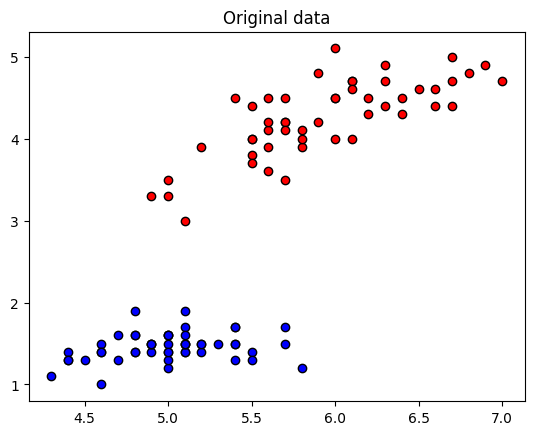

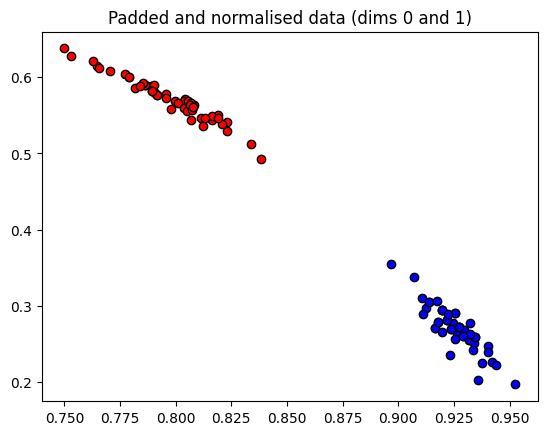

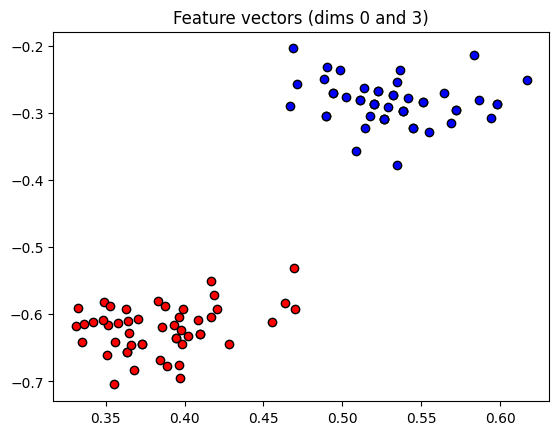

In [28]:
plt.figure()
plt.scatter(X[:, 0][Y == 1], X[:, 1][Y == 1], c="b", marker="o", ec="k")
plt.scatter(X[:, 0][Y == -1], X[:, 1][Y == -1], c="r", marker="o", ec="k")
plt.title("Original data")
plt.show()

plt.figure()
dim1 = 0
dim2 = 1
plt.scatter(X_norm[:, dim1][Y == 1], X_norm[:, dim2][Y == 1], c="b", marker="o", ec="k")
plt.scatter(X_norm[:, dim1][Y == -1], X_norm[:, dim2][Y == -1], c="r", marker="o", ec="k")
plt.title(f"Padded and normalised data (dims {dim1} and {dim2})")
plt.show()

plt.figure()
dim1 = 0
dim2 = 3
plt.scatter(features[:, dim1][Y == 1], features[:, dim2][Y == 1], c="b", marker="o", ec="k")
plt.scatter(features[:, dim1][Y == -1], features[:, dim2][Y == -1], c="r", marker="o", ec="k")
plt.title(f"Feature vectors (dims {dim1} and {dim2})")
plt.show()

In the previous example, we had separate training and test datasets. Here, we want to use our whole dataset and break it into two groups: The training one and the test one. We want to perform the training pipeline and test the performance of our model on the unseen data. We will adjust some hyperparameters.

In [29]:
np.random.seed(42)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

In [30]:
num_qubits = 2
num_layers = 6

weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

Several optimizers are available, but a common choice according to ([Optimizers](https://pennylane.ai/blog/2022/06/how-to-choose-your-optimizer/)) is GradientDescentOptimizer! Now this one seems a good choice for some datasets, but sometimes it's very slow in terms of convergence. Let's pursue optimization in action!

In [32]:
opt = GradientDescentOptimizer(stepsize=0.05)
batch_size = 5

# train the variational classifier
weights = weights_init
bias = bias_init
for it in range(140):
    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

    # Compute predictions on train and validation set
    predictions_train = np.sign(variational_classifier(weights, bias, feats_train.T))
    predictions_val = np.sign(variational_classifier(weights, bias, feats_val.T))

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)

    if (it + 1) % 2 == 0:
        _cost = cost(weights, bias, features, Y)
        print(
            f"Iter: {it + 1:5d} | Cost: {_cost:0.8f} | "
            f"Acc train: {acc_train:0.8f} | Acc validation: {acc_val:0.8f}"
        )

Iter:     2 | Cost: 1.27928278 | Acc train: 0.54666667 | Acc validation: 0.36000000
Iter:     4 | Cost: 1.04179080 | Acc train: 0.42666667 | Acc validation: 0.36000000
Iter:     6 | Cost: 1.16407001 | Acc train: 0.54666667 | Acc validation: 0.36000000
Iter:     8 | Cost: 1.03416159 | Acc train: 0.45333333 | Acc validation: 0.64000000
Iter:    10 | Cost: 1.35905486 | Acc train: 0.54666667 | Acc validation: 0.36000000
Iter:    12 | Cost: 1.29396969 | Acc train: 0.54666667 | Acc validation: 0.36000000
Iter:    14 | Cost: 1.04686413 | Acc train: 0.54666667 | Acc validation: 0.36000000
Iter:    16 | Cost: 0.99322620 | Acc train: 0.53333333 | Acc validation: 0.48000000
Iter:    18 | Cost: 1.08746115 | Acc train: 0.54666667 | Acc validation: 0.36000000
Iter:    20 | Cost: 1.24329465 | Acc train: 0.54666667 | Acc validation: 0.36000000
Iter:    22 | Cost: 1.03812184 | Acc train: 0.54666667 | Acc validation: 0.36000000
Iter:    24 | Cost: 1.14187824 | Acc train: 0.54666667 | Acc validation: 0.3

Running the previous cell multiple times gives different values for training and test accuracies! This may be a direct hint to the limitations of the optimizer in this case. 

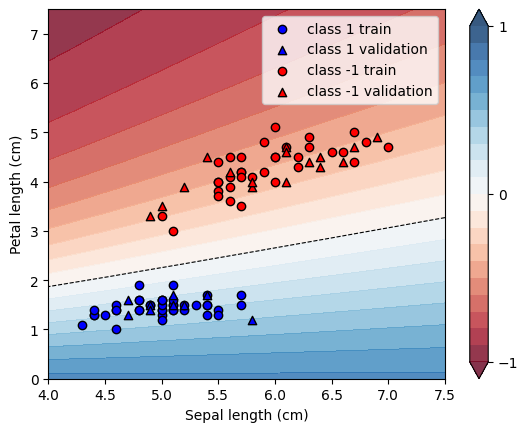

In [33]:
plt.figure()
cm = plt.cm.RdBu

# make data for decision regions
xx, yy = np.meshgrid(np.linspace(4.0, 7.5, 30), np.linspace(0.0, 7.5, 30))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

# preprocess grid points like data inputs above
padding = np.ones((len(X_grid), 2))
X_grid = np.c_[X_grid, padding]  # pad each input
normalization = np.sqrt(np.sum(X_grid**2, -1))
X_grid = (X_grid.T / normalization).T  # normalize each input
features_grid = np.array([get_angles(x) for x in X_grid])  # angles are new features
predictions_grid = variational_classifier(weights, bias, features_grid.T)
Z = np.reshape(predictions_grid, xx.shape)

# plot decision regions
levels = np.arange(-1, +1.1, 0.1)
cnt = plt.contourf(xx, yy, Z, levels=levels, cmap=cm, alpha=0.8, extend="both")
plt.contour(xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[+1, 0, -1])

# plot data
for color, label in zip(["b", "r"], [1, -1]):
    plot_x = X_train[:, 0][Y_train == label]
    plot_y = X_train[:, 1][Y_train == label]
    plt.scatter(plot_x, plot_y, c=color, marker="o", ec="k", label=f"class {label} train")
    plot_x = (X_val[:, 0][Y_val == label],)
    plot_y = (X_val[:, 1][Y_val == label],)
    plt.scatter(plot_x, plot_y, c=color, marker="^", ec="k", label=f"class {label} validation")

plt.xlabel('Sepal length (cm)')
plt.ylabel('Petal length (cm)')
plt.legend()
plt.show()

Indeed VQC found a separation between the datasets both in training and test formats. The choice of the optimizer and other hyperparameters are extremely important for achieving good results.

## ***Further Directions:***

We end this task by mentioning another scheme, appropriate for supervised classification problems. As opposed to the variational nature of the above methods (VQC), there are kernel-based methods that can be utilized for (mostly yet not exclusively) classification tasks. One can consider the implementation of Quantum Kernel Support Vector Machine (QK-SVM) and Quantum Variational Support Vector Machine (QV-SVM), according to this Pennylane tutorial ([kernel_training](https://pennylane.ai/qml/demos/tutorial_kernel_based_training/)), and then, the next step that we wish to scrutinize would be the blending of those, meaning Quantum Variational Kernel Support Vector Machine (QVK-SVM), which has been the goal of this paper ([QVK-SVM](https://arxiv.org/abs/2305.06063)).